In [1]:
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, Model, optimizers, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer

2025-07-03 07:21:34.606443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751527294.824653      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751527294.890112      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [3]:
captions = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

# Data Preprocessing

In [4]:
def captionPreprocessing(caption):
    caption = caption.lower()
    caption = ''.join(c for c in caption if c.isalnum() or c.isspace())
    caption = f"<start> {caption} <end>"
    return caption

captions['cleanedCaption'] = captions['caption'].apply(captionPreprocessing)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(captions['cleanedCaption'])

sequences = tokenizer.texts_to_sequences(captions['cleanedCaption'])

max_length = max([len(seq) for seq in sequences])

padded_sequences = pad_sequences(sequences, maxlen = max_length, padding = 'post')
vocab_size = len(tokenizer.word_index) + 1
vocabulary = tokenizer.word_index

# Define Label

In [ ]:
def lengthCaption(caption_length):
    if caption_length < 15:
        return 'short'
    elif caption_length <= 20:
        return 'medium'
    else:
        return 'long'

captions['cleanedLength'] = captions['cleanedCaption'].apply(lambda x: len(x.split()))
captions['label'] = captions['cleanedLength'].apply(lengthCaption)

# Train Test Split

In [6]:
labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(captions['label'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size = 0.2, random_state = 42)

# Caption Classification | RNN + LSTM

In [7]:
model_rnn_lstm = Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = 256, input_length = X_train.shape[1]),
    layers.SimpleRNN(256, return_sequences = True),
    layers.LSTM(256, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(3, activation = 'softmax'),
])

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduceLRONPlateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose = 1)
callbacks = [earlyStopping, reduceLRONPlateau]

optimizer = optimizers.Adam(learning_rate=1e-3, clipvalue = 1.0)
model_rnn_lstm.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history_rnn_lstm = model_rnn_lstm.fit(X_train, y_train, epochs = 20, batch_size = 32, callbacks = callbacks, validation_data = (X_test, y_test))

model_rnn_lstm.save('/kaggle/working/model_rnn_lstm.keras')
with open('/kaggle/working/model_rnn_lstm.pkl', 'wb') as f:
    pickle.dump(history_rnn_lstm.history, f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


I0000 00:00:1751527320.236550      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751527320.237262      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1751527327.460826      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - accuracy: 0.9405 - loss: 0.1666 - val_accuracy: 1.0000 - val_loss: 1.3522e-04 - learning_rate: 0.0010
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 1.0000 - loss: 2.2489e-04 - val_accuracy: 1.0000 - val_loss: 1.3760e-05 - learning_rate: 0.0010
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 1.0000 - loss: 8.7653e-05 - val_accuracy: 1.0000 - val_loss: 2.7403e-06 - learning_rate: 0.0010
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.9731e-05
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 1.0000 - loss: 2.9731e-05 - val_accuracy: 1.0000 - val_loss: 1.1515e-06 - learning_rate: 0.0010
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 1.0000 - loss: 8.6211e-06 - val_accuracy: 1.0000 - val_loss: 7.7655e-07 - learning_rate: 5.0000e-04
Epoch 6/20
1012/1012 ━━━━━━━━━━━━

# Caption Classification | GRU + BiLSTM

In [8]:
inputs = layers.Input(shape = (max_length, ))
x = layers.Embedding(input_dim = vocab_size, output_dim = 256, input_length = X_train.shape[1])(inputs)
x = layers.GRU(256, return_sequences = True)(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation = 'relu')(x)
outputs = layers.Dense(3, activation = 'softmax')(x)

model_gru_bilstm = Model(inputs, outputs)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
reduceLRONPlateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose = 1)
callbacks = [earlyStopping, reduceLRONPlateau]

optimizer = optimizers.Adam(learning_rate=1e-3, clipvalue = 1.0)
model_gru_bilstm.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history_gru_bilstm = model_gru_bilstm.fit(X_train, y_train, epochs = 20, batch_size = 32, callbacks = callbacks, validation_data = (X_test, y_test))

model_gru_bilstm.save('/kaggle/working/model_gru_bilstm.keras')
with open('/kaggle/working/model_gru_bilstm.pkl', 'wb') as f:
    pickle.dump(history_gru_bilstm.history, f)

Epoch 1/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9055 - loss: 0.2383 - val_accuracy: 0.9004 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 2/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9574 - loss: 0.1007 - val_accuracy: 0.9047 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 3/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9840 - loss: 0.0427 - val_accuracy: 0.9963 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 4/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9935 - loss: 0.0178 - val_accuracy: 0.9998 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 4.9780e-04 - learning_rate: 0.0010
Epoch 6/20
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9911 - loss: 0.0267 - val_accuracy: 0.9999 - val_loss: 5.6332e-04 - learning_rate: 0.0010
Epoch 7/20
1009/1012 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step -

# Caption Classification | DistilBERT

In [34]:
Tokenizer = DistilBertTokenizer.from_pretrained('/kaggle/input/distillbert/other/default/1/distilbert-base-uncased')
inputs = Tokenizer(captions['cleanedCaption'].tolist(), padding=True, truncation=True, return_tensors='np', max_length = max_length)

X_Train, X_Test, y_Train, y_Test = train_test_split(inputs['input_ids'], labels, test_size = 0.2)
train_dataset = tf.data.Dataset.from_tensor_slices((X_Train, y_Train)).batch(32)
test_dataset =  tf.data.Dataset.from_tensor_slices((X_Test, y_Test)).batch(32)

In [ ]:
   q q

Some layers from the model checkpoint at /kaggle/input/distillbert/other/default/1/distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distillbert/other/default/1/distilbert-base-uncased and are newly initialized: ['dropout_79', 'classifier', 'pre_classif

Epoch 1/10
1012/1012 [==============================] - 164s 139ms/step - loss: 1.1012 - accuracy: 0.6784 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 2/10
1012/1012 [==============================] - 136s 134ms/step - loss: 1.0986 - accuracy: 0.6924 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 3/10
1012/1012 [==============================] - 136s 134ms/step - loss: 1.0986 - accuracy: 0.6936 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 4/10
1012/1012 [==============================] - 136s 135ms/step - loss: 1.0986 - accuracy: 0.6925 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 5/10
1012/1012 [==============================] - 136s 134ms/step - loss: 1.0986 - accuracy: 0.6923 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 6/10
1012/1012 [==============================] - 136s 135ms/step - loss: 1.0986 - accuracy: 0.6947 - val_loss: 1.0986 - val_accuracy: 0.7028
Epoch 7/10
1012/1012 [==============================] - 136s 135ms/step - loss: 1.0986 - accuracy: 0.6925 - val_

# Load Models

In [9]:
model_rnn_lstm = keras.models.load_model('/kaggle/input/classification/other/default/1/captionClassification/model_rnn_lstm.keras')
with open('/kaggle/input/classification/other/default/1/captionClassification/model_rnn_lstm.pkl', 'rb') as f:
    history_rnn_lstm = pickle.load(f)

model_gru_bilstm = keras.models.load_model('/kaggle/input/classification/other/default/1/captionClassification/model_gru_bilstm.keras')
with open('/kaggle/input/classification/other/default/1/captionClassification/model_gru_bilstm.pkl', 'rb') as f:
    history_gru_bilstm = pickle.load(f)

DistilBERT = TFDistilBertForSequenceClassification.from_pretrained("/kaggle/input/distilbert/other/default/1/DistilBERT/DistilBERT")
Tokenizer = DistilBertTokenizer.from_pretrained("/kaggle/input/distilbert/other/default/1/DistilBERT/DistilBERT")
with open('/kaggle/input/distilbert/other/default/1/DistilBERT/DistilBERT.pkl', 'rb') as f:
    historyDistilBERTm = pickle.load(f)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /kaggle/input/distilbert/other/default/1/DistilBERT/DistilBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


# Visualize Metrics

In [45]:
def plotResults(history, model_name = 'Model'):
    metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']

    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Train {metric}')
        ax.plot(epochs, history[val_metric], label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()

    plt.suptitle(model_name, fontsize = 16)
    plt.tight_layout()
    plt.show()

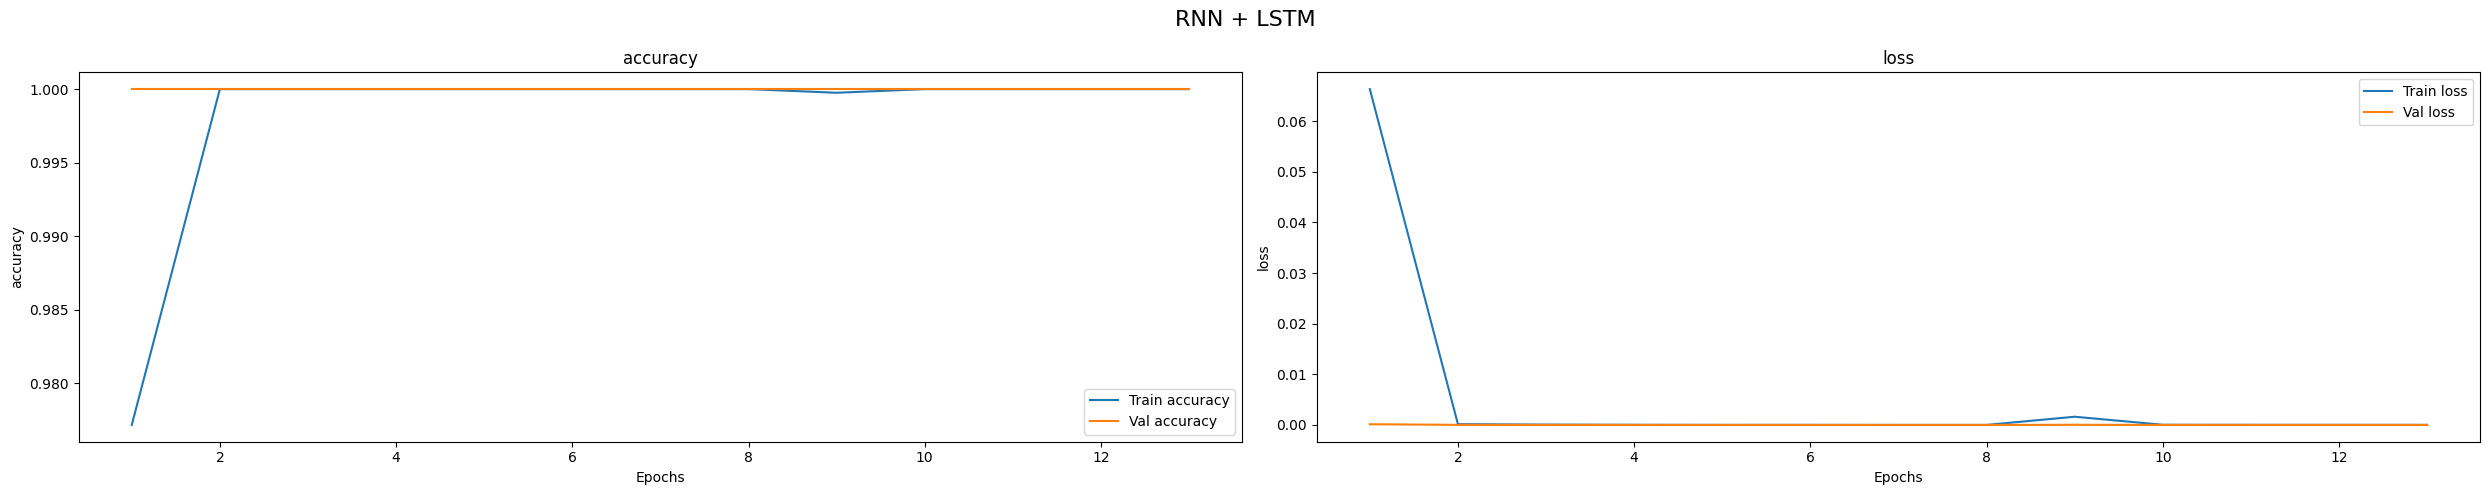

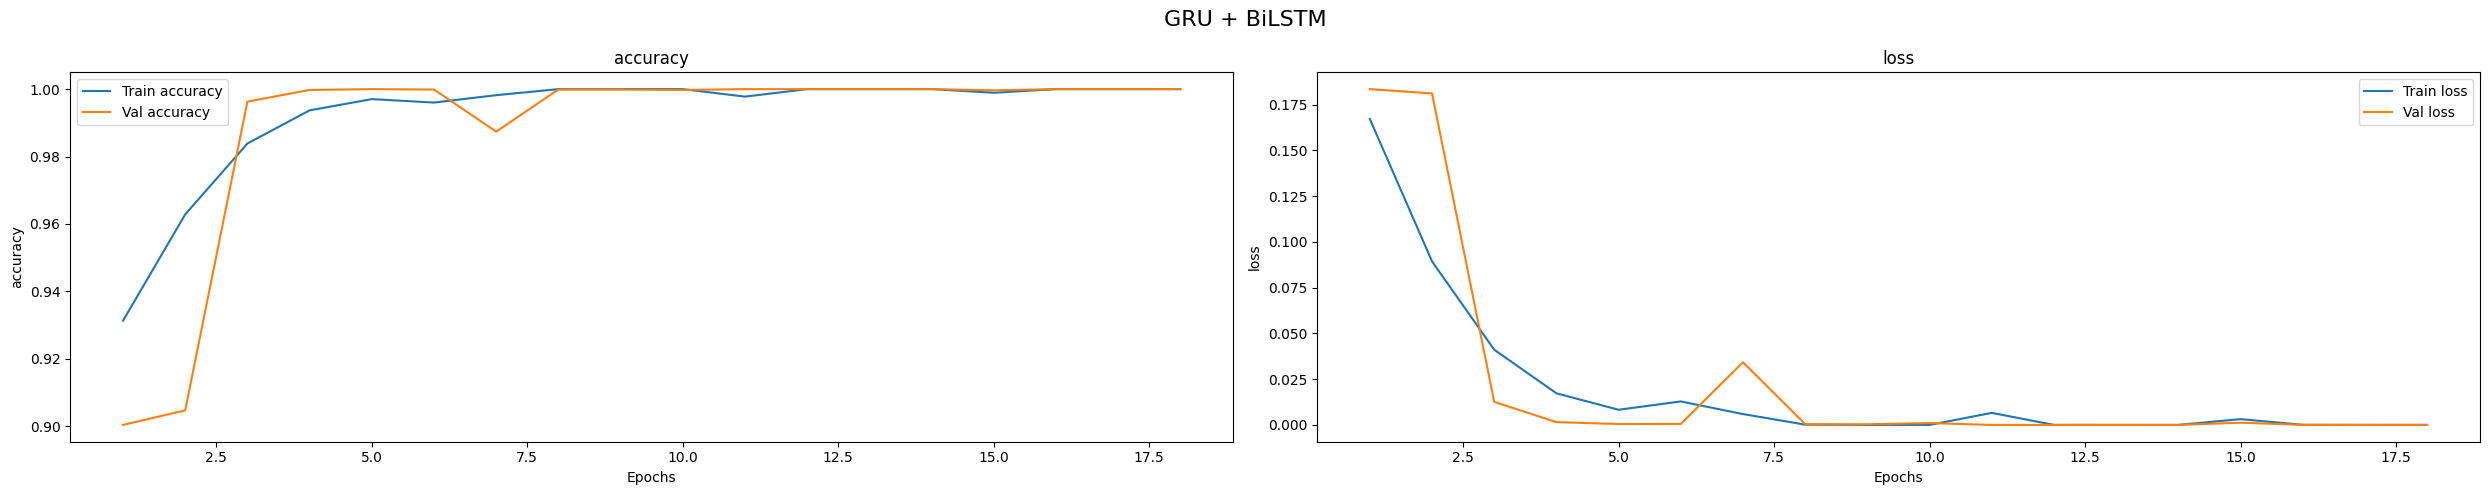

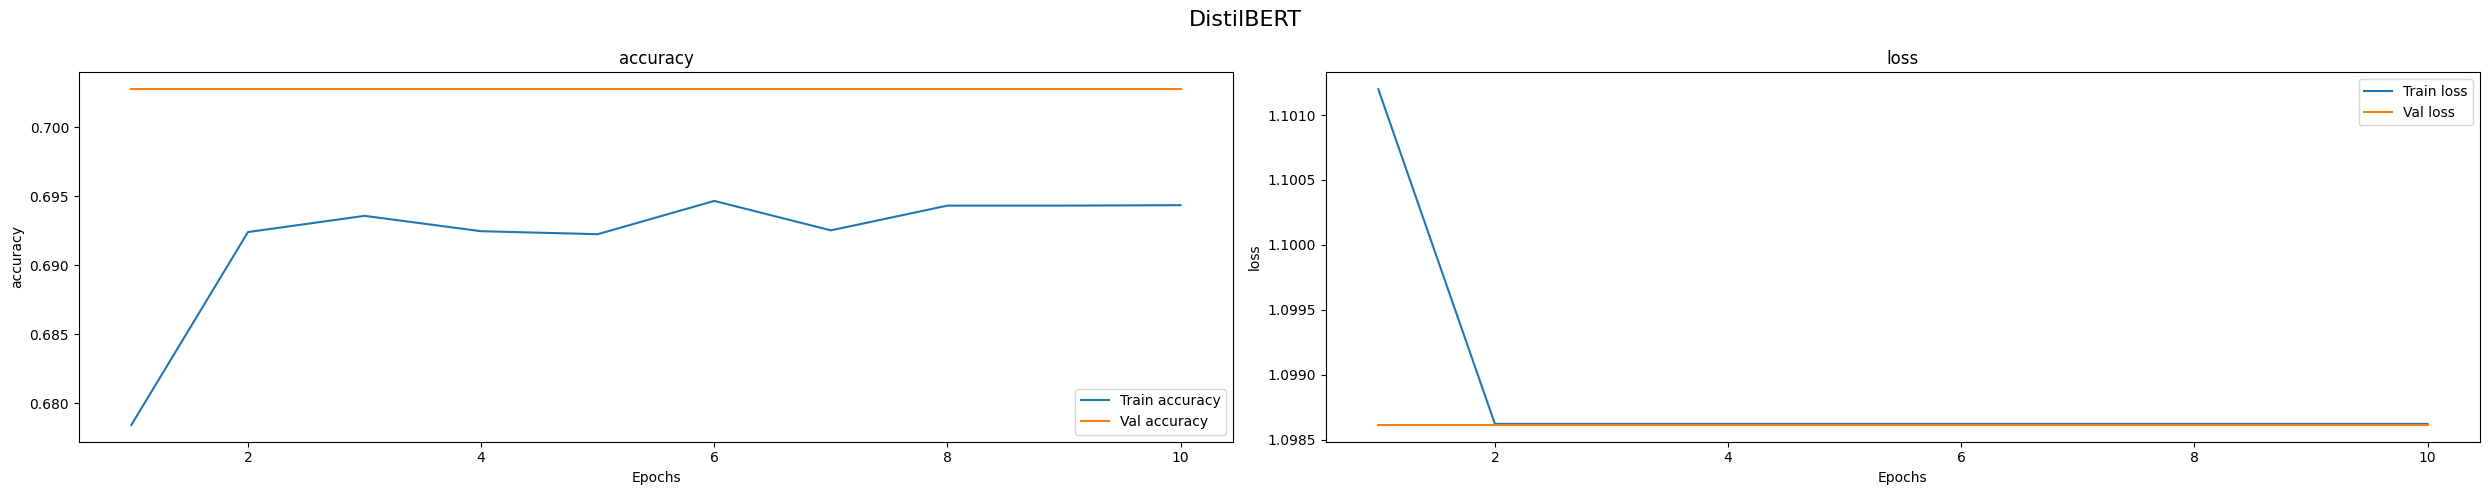

In [49]:
plotResults(history_rnn_lstm, model_name = 'RNN + LSTM')
plotResults(history_gru_bilstm, model_name = 'GRU + BiLSTM')
plotResults(historyDistilBERT, model_name = 'DistilBERT')

# Evaluation

In [55]:
y_pred_probs_rnn_lstm = model_rnn_lstm.predict(X_test)
y_pred_rnn_lstm = tf.argmax(y_pred_probs_rnn_lstm, axis = 1)

y_pred_probs_gru_bilstm = model_gru_bilstm.predict(X_test)
y_pred_gru_bilstm = tf.argmax(y_pred_probs_gru_bilstm, axis = 1)

253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [56]:
rnn_lstm_acc = accuracy_score(y_test, y_pred_rnn_lstm)
gru_bilstm_acc = accuracy_score(y_test, y_pred_gru_bilstm)
print(f"Accuracy of RNN + LSTM: {rnn_lstm_acc}")
print(f"Accuracy of GRU + BiLSTM: {gru_bilstm_acc}")

Accuracy of RNN + LSTM: 1.0
Accuracy of GRU + BiLSTM: 1.0


In [57]:
rnn_lstm_f1 = f1_score(y_test, y_pred_rnn_lstm, average = 'weighted')
gru_bilstm_f1 = f1_score(y_test, y_pred_gru_bilstm, average = 'weighted')
print(f"F1 score of RNN + LSTM: {rnn_lstm_f1}")
print(f"F1 score of GRU + BiLSTM: {gru_bilstm_f1}")

F1 score of RNN + LSTM: 1.0
F1 score of GRU + BiLSTM: 1.0


In [74]:
print(f"Number of epochs before Early Stopping occur of RNN + LSTM: {len(history_rnn_lstm['loss'])}")
print(f"Number of epochs before Early Stopping occur of GRU + BiLSTM + Attention: {len(history_gru_bilstm['loss'])}")

Number of epochs before Early Stopping occur of RNN + LSTM: 13
Number of epochs before Early Stopping occur of GRU + BiLSTM + Attention: 18


In [61]:
index_word = {index : word for word, index in vocabulary.items()}

DistilBERT_texts = []
for data in X_test:
    sentence = []
    for char in data:
        if char != 0:
            text = index_word.get(char, '<OOV>')
            sentence.append(text)
    DistilBERT_texts.append(' '.join(sentence))

inputs = Tokenizer(DistilBERT_texts[:1000], return_tensors="tf", truncation=True, padding=True)

logits = DistilBERT(**inputs).logits
predicted = tf.argmax(logits, axis=1).numpy()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
DistilBERT_acc = accuracy_score(y_Test[:1000], predicted)
print(f"Accuracy of DistilBERT on 1000 samples: {DistilBERT_acc}")
print()

DistilBERT_f1 = f1_score(y_Test[:1000], predicted, average = 'weighted')
print(f"F1 score of DistilBERT on 1000 samples: {DistilBERT_f1}")
print()

print(f"Number of epochs of DistilBERT: {len(historyDistilBERT.history['loss'])}") 

Accuracy of DistilBERT on 1000 samples: 0.263

F1 score of DistilBERT on 1000 samples: 0.1680497320140177

Number of epochs of DistilBERT: 10


# Inference

In [78]:
sample_text = [
    ''.join(
        (list(vocabulary.keys())[char - 1] + ' ') if char != 0 and char != 3 else 
        (list(vocabulary.keys())[char - 1] if char == 3 else '')
        for char in X_test[i]
    )
    for i in range(5)
]

inference_probs = model_rnn_lstm.predict(X_test[:5])
inference = tf.argmax(inference_probs, axis = 1)

for i in range(5):
    print(sample_text[i])
    print(f"Predicted Label RNN + LSTM: {inference.numpy()[i]}")
    print(f"Grouth True Label: {y_test[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
start a large wild cat is pursuing a horse across a meadow end
Predicted Label RNN + LSTM: 2
Grouth True Label: 2

start two brown dogs fight on the leafy ground end
Predicted Label RNN + LSTM: 2
Grouth True Label: 2

start a man in shorts is standing on a rock looking out at the view from the hilltop end
Predicted Label RNN + LSTM: 1
Grouth True Label: 1

start a muzzled white dog is running on the grass end
Predicted Label RNN + LSTM: 2
Grouth True Label: 2

start a person skiing downhill end
Predicted Label RNN + LSTM: 2
Grouth True Label: 2



In [91]:
sample_text = [
    ''.join(
        (list(vocabulary.keys())[char - 1] + ' ') if char != 0 and char != 3 else 
        (list(vocabulary.keys())[char - 1] if char == 3 else '')
        for char in X_test[i]
    )
    for i in range(5)
]

inference_probs = model_gru_bilstm.predict(X_test[:5])
inference = tf.argmax(inference_probs, axis = 1)

for i in range(5):
    print(sample_text[i])
    print(f"Predicted Label GRU + BiLSTM: {inference.numpy()[i]}")
    print(f"Grouth True Label: {y_test[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
start a large wild cat is pursuing a horse across a meadow end
Predicted Label GRU + BiLSTM: 2
Grouth True Label: 2

start two brown dogs fight on the leafy ground end
Predicted Label GRU + BiLSTM: 2
Grouth True Label: 2

start a man in shorts is standing on a rock looking out at the view from the hilltop end
Predicted Label GRU + BiLSTM: 1
Grouth True Label: 1

start a muzzled white dog is running on the grass end
Predicted Label GRU + BiLSTM: 2
Grouth True Label: 2

start a person skiing downhill end
Predicted Label GRU + BiLSTM: 2
Grouth True Label: 2



In [90]:
inputs = Tokenizer(DistilBERT_texts[:5], return_tensors="tf", truncation=True, padding=True)

logits = DistilBERT(**inputs).logits
predicted = tf.argmax(logits, axis=1).numpy()

for i in range(5):
    print(DistilBERT_texts[i])
    print(f"Predicted Label DistilBERT: {predicted[i]}")
    print(f"Grouth True Label: {y_Test[i]}")
    print()

start a large wild cat is pursuing a horse across a meadow end
Predicted Label DistilBERT: 1
Grouth True Label: 2

start two brown dogs fight on the leafy ground end
Predicted Label DistilBERT: 1
Grouth True Label: 1

start a man in shorts is standing on a rock looking out at the view from the hilltop end
Predicted Label DistilBERT: 1
Grouth True Label: 2

start a muzzled white dog is running on the grass end
Predicted Label DistilBERT: 1
Grouth True Label: 1

start a person skiing downhill end
Predicted Label DistilBERT: 2
Grouth True Label: 1

